# Plasmonic Yagi-Uda nanoantenna

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

Antennas are the fundamental building blocks for high-speed communication networks. The concept of an antenna is well-established, particularly in RF and microwave engineering, dating back over one century ago. An antenna transforms propagating electromagnetic waves to localized electromagnetic field and vice versa, depending on whether it is in the transmitting mode or receiving mode. Thus, it enables wireless communication and information transmission over long distances. 

Recent rapid developments in nanotechnology have sparked vast interest in constructing the optical counterpart of antennas by utilizing the plasmonic nature of metal at optical frequencies. The size of these antennas is usually in the order of 100 nm. Therefore, they are often termed plasmonic nanoantennas. As the demand for higher bandwidth information transmission keeps growing, plasmonic nanoantennas potentially be the technological cornerstone for future communication systems.

In this example notebook, we demonstrate the modeling of a plasmonic Yagi-Uda nanoantenna made of aluminum nanorods excited by a point dipole source. The far-field radiation pattern is calculated. We show that the simulated plasmonic Yagi-Uda nanoantenna can achieve a high directivity, which is desirable in many applications. The model is based on [Tim H. Taminiau, Fernando D. Stefani, and Niek F. van Hulst, "Enhanced directional excitation and emission of single emitters by a nano-optical Yagi-Uda antenna," Opt. Express 16, 10858-10866 (2008)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-16-14-10858&id=167282).

<img src="img/yagi_uda_antenna_schematic_1.png">

## Simulation Setup 

In this model, we are going to fit the refractive index of aluminum using data from the literature. Thus, we import the [DispersionFitter](../_autosummary/tidy3d.plugins.DispersionFitter.html) from the Tidy3D plugins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.dispersion import DispersionFitter


As schematically shown above, a typical Yagi-Uda antenna consists of three components: a feed element that is excited by a source, a reflector element that suppresses the radiation in the backward direction, and an array of director elements that enhances the radiation in the forward direction. Usually, having a large number of director elements is beneficial for achieving a high directivity. In practice, we need to consider the footprint, fabrication constraints, costs, and so on. In this particular example, our Yagi-Uda antenna has three director elements. All elements are made of aluminum nanorods with rounded ends.  

The lengths and spacings of the elements are designed to achieve optimal performance at 570 nm wavelength. An initial design can be obtained by following the classical design principle of RF/microwave Yagi-Uda antennas. Since metals behave very differently in lower frequencies compared to optical frequencies, the parameters need to be optimized to account for the finite skin depth and ohmic loss. In this notebook, we skip the optimization process and only present the optimized design from the referenced paper. 

In [2]:
lda0 = 0.57  # operation wavelength
freq0 = td.C_0 / lda0  # operation frequency


The nanorods are made of aluminum. Before constructing the model, we first need to use the [DispersionFitter](../_autosummary/tidy3d.plugins.DispersionFitter.html) to fit the refractive index data of aluminum, which can be found in the [refractive index database](https://refractiveindex.info/). In particular, we use the data from [McPeak et al. 2015](https://pubs.acs.org/doi/10.1021/ph5004237). Since we are only interested in the antenna response at 570 nm, we only need to fit the refractive index in the vicinity of the operation wavelength.

The fitting results in a RMS error about of 0.01, which is reasonably good.

In [3]:
fname = "misc/McPeak.csv"  # read the refractive index data from a csv file
fitter = DispersionFitter.from_file(fname, delimiter=",")  # construct a fitter
al, rms_error = fitter.fit(num_poles=6, tolerance_rms=2e-2, num_tries=50)


Output()

Next, we construct the Yagi-Uda antenna by individually constructing the feed, reflector, and three directors. Each element consists of a cylinder and two spheres that represent the rounded caps on each end. For convenience, we define a function to build the antenna structures since it will be used repeatedly in the next section of this notebook.

In [4]:
# L_f is the length of the feed element
# r is the radius of the nanorods.
# medium is the material of the nanorods
def construct_antenna(L_f, r, lda0, medium):
    L_r = L_f * 1.25  # length of the reflector
    L_d = L_f * 0.9  # length of the directors
    a_r = lda0 / 4.4  # spacing between the feed and the reflector
    a_d = (
        lda0 / 4
    )  # spacing between the feed and the first director (also the spacing between directors)

    feed = [
        td.Structure(
            geometry=td.Cylinder(
                center=(0, 0, 0), radius=r, length=L_f - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(0, (L_f - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(0, -(L_f - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    reflector = [
        td.Structure(
            geometry=td.Cylinder(
                center=(-a_r, 0, 0), radius=r, length=L_r - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(-a_r, (L_r - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(-a_r, -(L_r - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    director_1 = [
        td.Structure(
            geometry=td.Cylinder(
                center=(a_d, 0, 0), radius=r, length=L_d - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(a_d, (L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(a_d, -(L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    director_2 = [
        td.Structure(
            geometry=td.Cylinder(
                center=(2 * a_d, 0, 0), radius=r, length=L_d - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(2 * a_d, (L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(2 * a_d, -(L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    director_3 = [
        td.Structure(
            geometry=td.Cylinder(
                center=(3 * a_d, 0, 0), radius=r, length=L_d - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(3 * a_d, (L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(3 * a_d, -(L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    antenna = feed + reflector + director_1 + director_2 + director_3
    return antenna


L_f = 0.16  # length of the feed
r = 0.02  # radius of the nanorods
medium = al  # material of the antenna

antenna = construct_antenna(L_f, r, lda0, medium)


The Yagi-Uda antenna is usually fed by a small quantum emitter such as a laser-excited quantum dot. In the simulation, the source can be well approximated as a [PointDipole](../_autosummary/tidy3d.PointDipole.html), which is what we are going to use.

To calculate the far-field radiation pattern and directivity, we will use the [FieldProjectionAngleMonitor](../_autosummary/tidy3d.FieldProjectionAngleMonitor.html) as well as a [FluxMonitor](../_autosummary/tidy3d.FluxMonitor.html). The [FieldProjectionAngleMonitor](../_autosummary/tidy3d.FieldProjectionAngleMonitor.html) yields the angular radiation power and the [FluxMonitor](../_autosummary/tidy3d.FluxMonitor.html) helps to calculate the total radiated power. Both are required in the calculation of directivity.

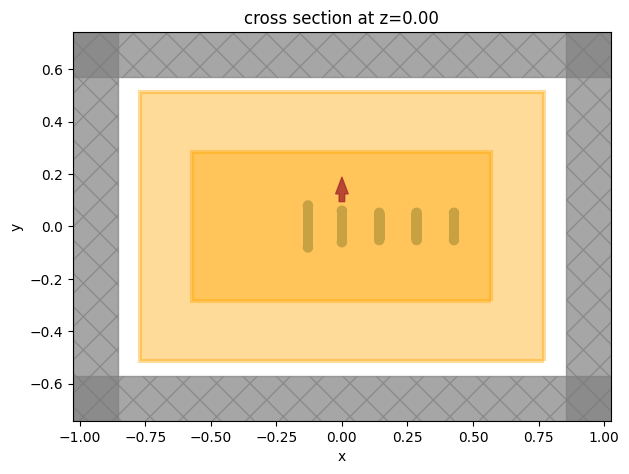

In [5]:
# define simulation domain size
Lx = 3 * lda0
Ly = 2 * lda0
Lz = 2 * lda0
sim_size = (Lx, Ly, Lz)

# create an electrical point dipole source polarized in the y direction to excite the feed element
d_dp = 0.004  # distance between the dipole and the feed element
pulse = td.GaussianPulse(freq0=freq0, fwidth=freq0 / 20)
pt_dipole = td.PointDipole(
    center=(0, L_f / 2 + d_dp, 0), source_time=pulse, polarization="Ey"
)

# create a FieldProjectionAngleMonitor to perform the near field to far field transformation in spherical coordinates
theta_array = np.linspace(0, 2 * np.pi, 200)
phi_array = np.linspace(0, np.pi, 100)
n2f_monitor = td.FieldProjectionAngleMonitor(
    center=(0, 0, 0),
    size=(2 * lda0, 1 * lda0, 1 * lda0),
    freqs=[freq0],
    name="n2f_monitor",
    custom_origin=(0, 0, 0),
    phi=phi_array,
    theta=theta_array,
)

# create a flux monitor to calculate the total radiated power
flux_monitor = td.FluxMonitor(
    center=(0, 0, 0),
    size=(Lx * 0.9, Ly * 0.9, Lz * 0.9),
    freqs=[freq0],
    name="power",
)

# create the simulation with the above defined elements
sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=antenna,
    sources=[pt_dipole],
    monitors=[n2f_monitor, flux_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

# visualize the simulation setup
sim.plot(z=0)
plt.show()


For comparison, define an empty simulation with only the [PointDipole](../_autosummary/tidy3d.PointDipole.html). We will use this to show that the Yagi-Uda antenna exhibits a much higher directivity compared to a dipole radiation source.

In [6]:
sim_empty = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=[],  # this simulation is identical to the previous one besides the structures is set to an empty list
    sources=[pt_dipole],
    monitors=[n2f_monitor, flux_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


Submit both the antenna simulation and empty simulation to the server.

In [7]:
sim_data = web.run(
    sim, task_name="plasmonic_yagi_uda", path="data/optical_yagi_uda.hdf5", verbose=True
)
sim_empty_data = web.run(
    sim_empty, task_name="empty", path="data/optical_yagi_uda.hdf5", verbose=True
)


[19:19:21] Created task 'plasmonic_yagi_uda' with task_id                                             ]8;id=33877;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=13310;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#139\139]8;;\
           'fdve-caa7212c-4653-4d54-92a0-0ca8e7e40c55v1'.                                                          

Output()

[19:19:23] status = queued                                                                            ]8;id=402169;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=753197;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#269\269]8;;\

Output()

[19:19:29] status = preprocess                                                                        ]8;id=895396;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=465953;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[19:19:33] Maximum FlexCredit cost: 0.059. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=471689;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=940518;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#286\286]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=188792;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=895445;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#290\290]8;;\

           running solver                                                                             ]8;id=55000;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=10751;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[19:19:57] early shutoff detected, exiting.                                                           ]8;id=821075;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=716920;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#314\314]8;;\

           status = postprocess                                                                       ]8;id=298679;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=294985;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#331\331]8;;\

Output()

[19:20:00] status = success                                                                           ]8;id=395079;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=973684;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#338\338]8;;\

Output()

[19:20:01] loading SimulationData from data/optical_yagi_uda.hdf5                                     ]8;id=788294;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=915038;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#510\510]8;;\

[19:20:01] Created task 'empty' with task_id 'fdve-0622f415-c6f3-4e4c-88cf-ca07a52be11fv1'.           ]8;id=426554;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=186883;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#139\139]8;;\

Output()

[19:20:02] status = queued                                                                            ]8;id=499567;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=561849;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#269\269]8;;\

Output()

[19:20:09] status = preprocess                                                                        ]8;id=51274;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=130033;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[19:20:12] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=968999;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=346716;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#286\286]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=9288;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=586094;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#290\290]8;;\

           running solver                                                                             ]8;id=622168;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=805794;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[19:20:20] early shutoff detected, exiting.                                                           ]8;id=372378;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=129852;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#314\314]8;;\

           status = postprocess                                                                       ]8;id=547320;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=93141;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#331\331]8;;\

Output()

[19:20:22] status = success                                                                           ]8;id=878921;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=161980;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#338\338]8;;\

Output()

[19:20:23] loading SimulationData from data/optical_yagi_uda.hdf5                                     ]8;id=779050;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=427325;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#510\510]8;;\

## Postprocessing

After the simulations are complete, we calculate the directivity of the Yagi-Uda antenna and the single point dipole. The directivity is given by

<center> $D(\phi,\theta)=\frac{4\pi P(\phi,\theta)}{P_0}$,</center>

where $P$ is the angular radiated power and $P_0= \iint P(\phi,\theta) d\Omega$ is the total radiated power.

The result shows that the dipole has a directivity of around 1.5, which is expected for a dipole radiator. On the other hand, the Yagi-Uda antenna has a much higher forward directivity above 6. 

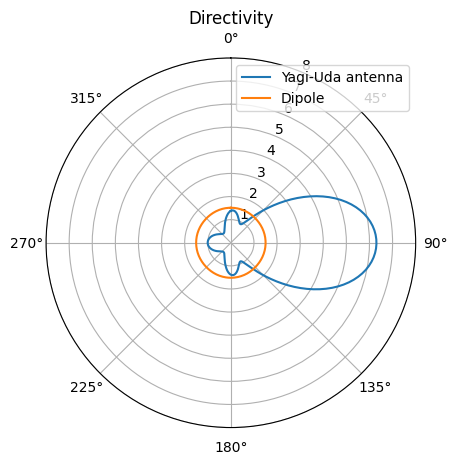

In [8]:
P0 = np.array(sim_data["power"].flux)  # total radiated power of the yagi-uda antenna

# angular radiated power of the yagi-uda antenna
# by default, the power is calculated at 1 meter away from the antenna. The 1e12 factor normalizes the power to unit distance (1 um)
P = 1e12 * sim_data["n2f_monitor"].power.sel(f=freq0, phi=0, method="nearest").values
P = np.squeeze(P)
D = 4 * np.pi * P / P0  # directivity of the yagi-uda antenna

P0_dp = np.array(
    sim_empty_data["power"].flux
)  # total radiated power of the point dipole
P_dp = (
    1e12
    * sim_empty_data["n2f_monitor"].power.sel(f=freq0, phi=0, method="nearest").values
)  # angular radiated power of the point dipole
P_dp = np.squeeze(P_dp)
D_dp = 4 * np.pi * P_dp / P0_dp  # directivity of the point dipole

# comparison of the directivity
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta_array, D, theta_array, D_dp)
ax.set_rlim(0, 8)
ax.set_title("Directivity")
ax.legend(("Yagi-Uda antenna", "Dipole"))
plt.show()


When studying antennas, very often we want to plot the full 3D radiation pattern. Here we show how to do so. This requires us to convert the spherical coordinates representation of the radiation pattern to Cartesian coordinates representation. 

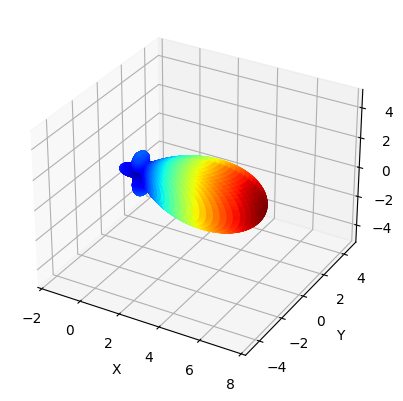

In [9]:
P = 1e12 * sim_data["n2f_monitor"].power.sel(f=freq0).values  # angular radiated power
D = 4 * np.pi * np.squeeze(P) / P0  # directivity

# convert the spherical coordinates representation to cartesian coordinates
phi, theta = np.meshgrid(phi_array, theta_array)
X = D * np.cos(phi) * np.sin(theta)
Y = D * np.sin(phi) * np.sin(theta)
Z = D * np.cos(theta)

R = np.sqrt(
    X**2 + Y**2 + Z**2
)  # distance to the center will be used to plot the color on top of the radiation pattern
R = R / np.max(R)  # normalize it to 1

color = plt.cm.jet(R)  # define colormap using the distance

# plotting the radiation pattern in 3d
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.set_xlim((-2, 8))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
surf = ax.plot_surface(
    X, Y, Z, cstride=1, rstride=1, facecolors=color, antialiased=True, shade=False
)


## Alternative Approach: Extending the Simulation Domain into the Far-Field Zone

Performing the near field to far field transformation using the [FieldProjectionAngleMonitor](../_autosummary/tidy3d.FieldProjectionAngleMonitor.html) is a great way to reduce the computational cost by limiting the simulation domain only to the vicinity of the antenna. However, there are certain limitations. For example, the transformation assumes a homogenous background medium. In practice, we often encounter inhomogeneous background such as when the antenna is placed on a dielectric substrate. 

Alternative to using the near field to far field transformation to obtain the far-field quantities, we can simply extend the simulation domain sufficiently far into the far-field zone. Here we harness the power of the highly optimized Tidy3D solver such that the simulation is still fast even when the domain size is large.

Next, we demonstrate this alternative approach and compare the result to the previous simulation to verify the accuracy.

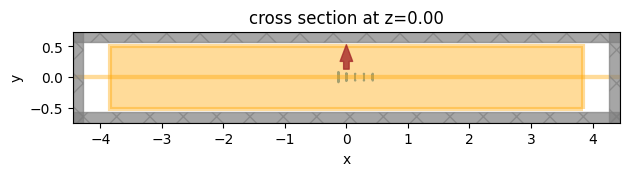

In [10]:
# compared to the previous simulation, this simulation uses a much larger simulation domain size
Lx = 15 * lda0
Ly = 2 * lda0
Lz = 15 * lda0
sim_size = (Lx, Ly, Lz)

# add a point dipole source
pulse = td.GaussianPulse(freq0=freq0, fwidth=freq0 / 20)
pt_dipole = td.PointDipole(
    center=(0, L_f / 2 + d_dp, 0), source_time=pulse, polarization="Ey"
)

# add a flux monitor to compute the total radiated power
flux_monitor = td.FluxMonitor(
    center=(0, 0, 0),
    size=(Lx * 0.9, Ly * 0.9, Lz * 0.9),
    freqs=[freq0],
    name="power",
)

# add a field monitor to compute the field far away from the antenna to calculate the directivity
field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq0],
    name="field",
)

# create the simulation with the above defined elements
sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=antenna,
    sources=[pt_dipole],
    monitors=[flux_monitor, field_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

# visualize the simulation setup
sim.plot(z=0)
plt.show()


Submit the simulation to the server.

In [11]:
sim_data = web.run(
    sim, task_name="plasmonic_yagi_uda", path="data/optical_yagi_uda.hdf5", verbose=True
)


[19:20:27] Created task 'plasmonic_yagi_uda' with task_id                                             ]8;id=273970;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=168043;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#139\139]8;;\
           'fdve-357143bf-0009-484d-b84d-335818718c1cv1'.                                                          

Output()

[19:20:28] status = queued                                                                            ]8;id=524958;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=779895;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#269\269]8;;\

Output()

[19:20:38] status = preprocess                                                                        ]8;id=816829;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=263842;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[19:20:45] Maximum FlexCredit cost: 0.746. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=90610;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=44199;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#286\286]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=644720;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=697674;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#290\290]8;;\

           running solver                                                                             ]8;id=858126;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=468364;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[19:22:48] early shutoff detected, exiting.                                                           ]8;id=452623;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=379611;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#314\314]8;;\

           status = postprocess                                                                       ]8;id=918126;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=600413;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#331\331]8;;\

Output()

[19:22:55] status = success                                                                           ]8;id=134393;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=84862;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#338\338]8;;\

Output()

[19:22:58] loading SimulationData from data/optical_yagi_uda.hdf5                                     ]8;id=769900;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=437940;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#510\510]8;;\

In this simulation, the way to calculate the directivity is a little different. The simulation domain size is 15$\lambda$. We can evaluate the radiated field at a circle 7$\lambda$ away from the antenna. At this distance, the near field should completely decay away so the field is purely radiated field. Therefore, the power is directly given by

<center>$P = \frac{E^2}{2\eta}$,</center>

where $E$ is the peak-to-peak electric field strength and $\eta=\eta_0/n$ is the intrinsic impedance of the medium. $\eta_0=377$ $\Omega$ is the free space impedance and $n$ is the refractive index.

As expected, the directivity pattern from this approach is practically identical to that from the near field to far field transformation, which verifies the validity of both methods.

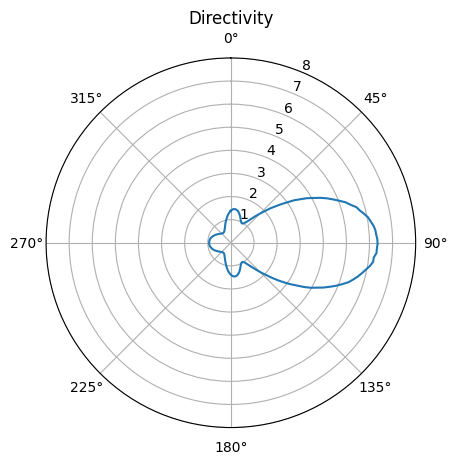

In [12]:
d = 7 * lda0  # distance at which the radiation pattern is evaluated
Z0 = 377  # free space impedance
P0 = np.array(sim_data["power"].flux)  # total radiated power

# evaluate the radiated power at 7*lda0 away from the antenna
P = np.zeros(len(theta_array))
for i, theta in enumerate(theta_array):
    Ex = sim_data["field"].Ex.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ey = sim_data["field"].Ey.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ez = sim_data["field"].Ez.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    P[i] = (
        d**2 * (abs(Ex) ** 2 + abs(Ey) ** 2 + abs(Ez) ** 2) / (2 * Z0)
    )  # we multiple the power by d^2 to normalize it to the power at unit distance
D = 4 * np.pi * P / P0  # directivity of the yagi-uda antenna

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta_array, D)
ax.set_rlim(0, 8)
ax.set_title("Directivity")
plt.show()


## Modeling Antenna on Substrate 

The approach of extending the simulation domain directly into the far-field zone really shows the benefit when the background medium is not uniform. Here we investigate such a case where a Yagi-Uda is placed on a glass substrate. It was predicted in the referenced paper that a lossless Yagi-Uda antenna on a glass substrate can achieve a directivity above 20, much higher than suspended in free space. 

For the lossless antenna, we will use PEC as the medium for the antenna structure. To make sure the mesh around the PEC domains is not excessively fine, we will utilize a mesh override structure and set the refractive index to 10. 

<img src="img/yagi_uda_antenna_schematic_2.png" width="500">

In [13]:
pec = td.PECMedium()  # pec medium

n_glass = 1.5  # glass has a refractive index of 1.5
glass = td.Medium(permittivity=n_glass**2)

L_f = 0.187  # length of the feed element
antenna_pec = construct_antenna(
    L_f, r, lda0, pec
)  # construct the lossless yagi-uda antenna with pec

inf_eff = 100  # effective infinity
# construct the substrate
sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -r)
    ),
    medium=glass,
)

# the whole structure is the antenna plus the substrate
antenna_pec.append(sub)

# to control the mesh around the antenna area, we construct a mesh override structure
# refractive index of the override structure is set to 10 to ensure sufficiently but not excessively fine mesh
refine_medium = td.Medium(permittivity=10**2)
antenna_refine = construct_antenna(
    L_f, r, lda0, refine_medium
)  # construct the mesh override structure


Construct the source, monitors, and simulation in a similar way to the previous simulation.

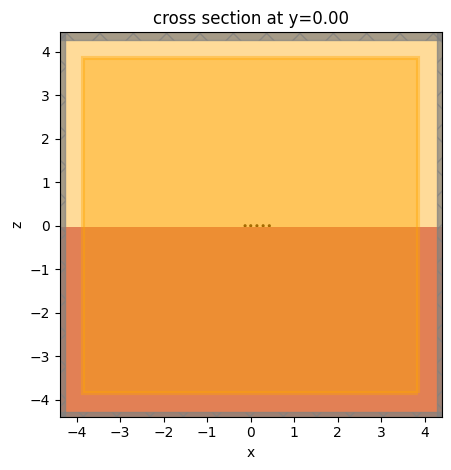

In [14]:
Lx = 15 * lda0
Ly = 2 * lda0
Lz = 15 * lda0
sim_size = (Lx, Ly, Lz)

pulse = td.GaussianPulse(freq0=freq0, fwidth=freq0 / 20)
pt_dipole = td.PointDipole(
    center=(0, L_f / 2 + d_dp, 0), source_time=pulse, polarization="Ey"
)

flux_monitor = td.FluxMonitor(
    center=(0, 0, 0),
    size=(Lx * 0.9, Ly * 0.9, Lz * 0.9),
    freqs=[freq0],
    name="power",
)

field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq0],
    name="field",
)

sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=40, wavelength=lda0, override_structures=antenna_refine
    ),
    structures=antenna_pec,
    sources=[pt_dipole],
    monitors=[flux_monitor, field_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

sim.plot(y=0)
plt.show()


Submit the simulation to the server.

In [15]:
sim_data = web.run(
    sim,
    task_name="plasmonic_yagi_uda_on_glass",
    path="data/optical_yagi_uda.hdf5",
    verbose=True,
)


[19:23:10] Created task 'plasmonic_yagi_uda_on_glass' with task_id                                    ]8;id=460525;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=741100;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#139\139]8;;\
           'fdve-87f2f913-4456-474d-ad99-e8b4aa3ac854v1'.                                                          

Output()

[19:23:11] status = queued                                                                            ]8;id=452121;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=712835;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#269\269]8;;\

Output()

[19:23:18] status = preprocess                                                                        ]8;id=148703;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=759898;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[19:23:28] Maximum FlexCredit cost: 3.070. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=223594;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=932179;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#286\286]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=509559;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=269531;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#290\290]8;;\

           running solver                                                                             ]8;id=536618;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=894571;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[19:24:46] early shutoff detected, exiting.                                                           ]8;id=67288;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=36389;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#314\314]8;;\

           status = postprocess                                                                       ]8;id=535487;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=730446;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#331\331]8;;\

Output()

[19:24:53] status = success                                                                           ]8;id=532354;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=846572;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#338\338]8;;\

Output()

[19:24:56] loading SimulationData from data/optical_yagi_uda.hdf5                                     ]8;id=83834;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=75583;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#510\510]8;;\

After the simulation is complete, we calculate the directivity in the same way as previously. Note that the intrinsic impedance $\eta=\eta_0/n$ is different in the glass ($n=1.5$) compared to in the free space ($n=1$). 

From the directivity plot, we can see that a directivity close to 25 can be achieved in this case.

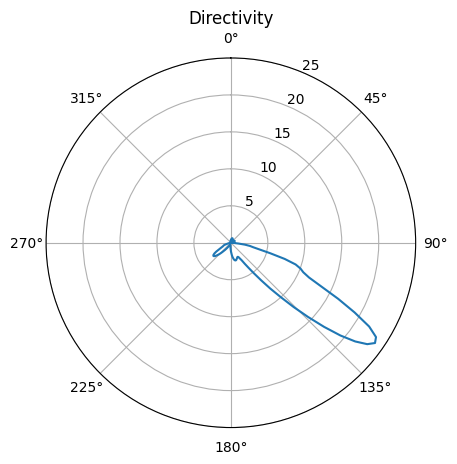

In [16]:
P0 = np.array(sim_data["power"].flux)  # total radiated power

# evaluate the radiated power at 7*lda0 away from the antenna
P = np.zeros(len(theta_array))
for i, theta in enumerate(theta_array):
    Ex = sim_data["field"].Ex.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ey = sim_data["field"].Ey.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ez = sim_data["field"].Ez.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    if d * np.cos(theta) > 0:
        P[i] = d**2 * (abs(Ex) ** 2 + abs(Ey) ** 2 + abs(Ez) ** 2) / (2 * Z0)
    else:
        # inside the substrate, the impedance of the glass needs to be taken into account
        P[i] = (
            n_glass * d**2 * (abs(Ex) ** 2 + abs(Ey) ** 2 + abs(Ez) ** 2) / (2 * Z0)
        )

D = 4 * np.pi * P / P0  # directivity

# plotting the directivity pattern
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta_array, D)
ax.set_rlim(0, 25)
ax.set_title("Directivity")
plt.show()
